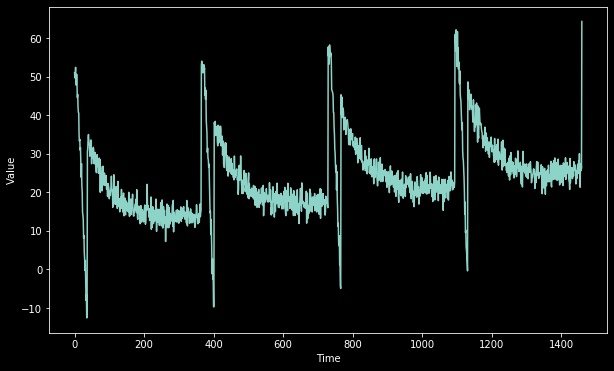

In [48]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

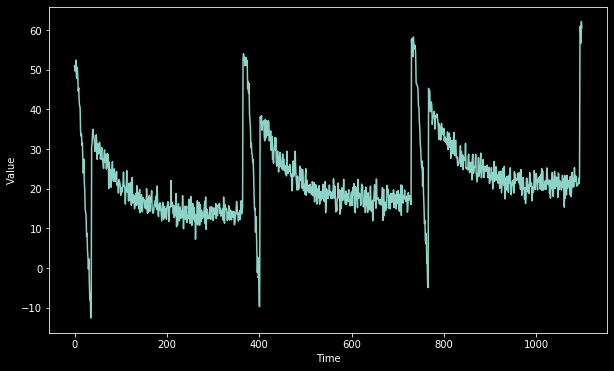

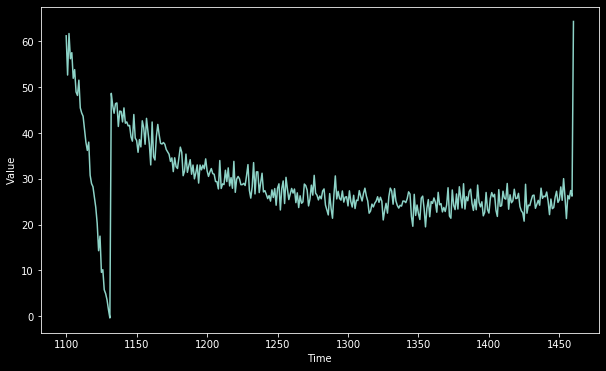

In [49]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

# Naive Forecast

In [50]:
naive_forecast = series[split_time-1 : -1]

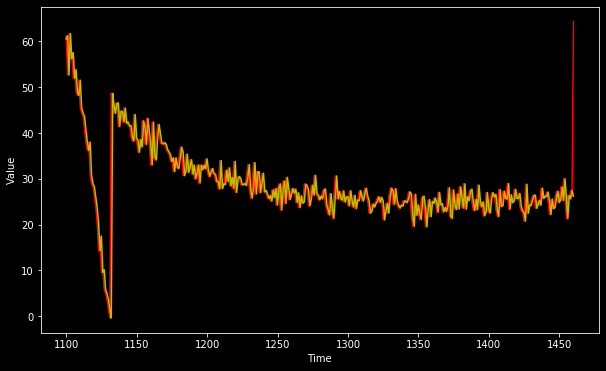

In [51]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, 'r-')
plot_series(time_valid, naive_forecast, 'y-')

# Expected output: Chart similar to above, but with forecast overlay

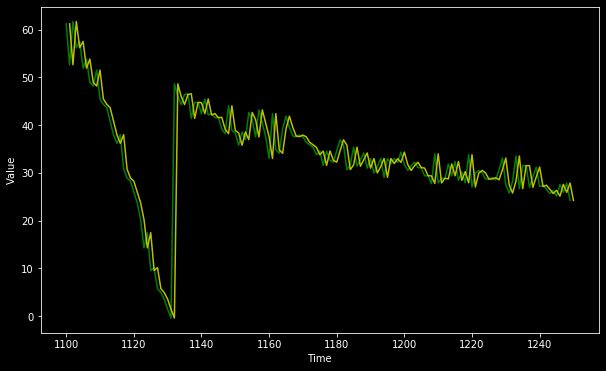

In [52]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, format='g-')
plot_series(time_valid, naive_forecast, start=1, end=151, format='y-')

# EXPECTED - Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped 1 unit 'after' series

In [53]:
print('MSE:',keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print('MAE:',keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

MSE: 19.578304
MAE: 2.6011972


In [54]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

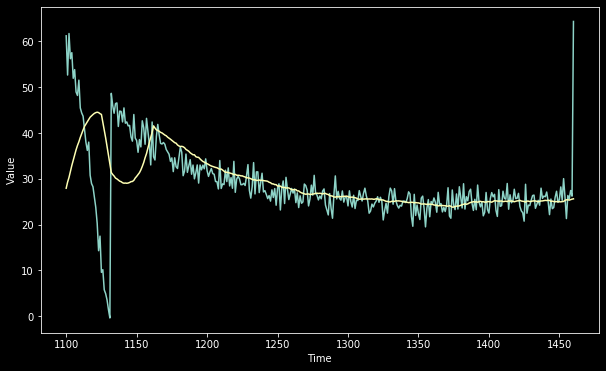

In [55]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
    
# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [56]:
print('MSE:', keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print('MAE:', keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

MSE: 65.786224
MAE: 4.3040023


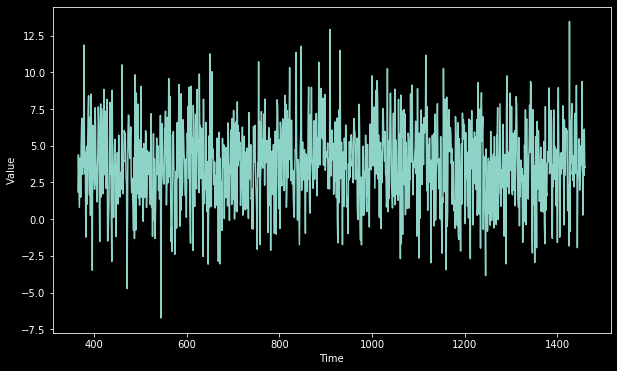

In [58]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series)
plt.show()

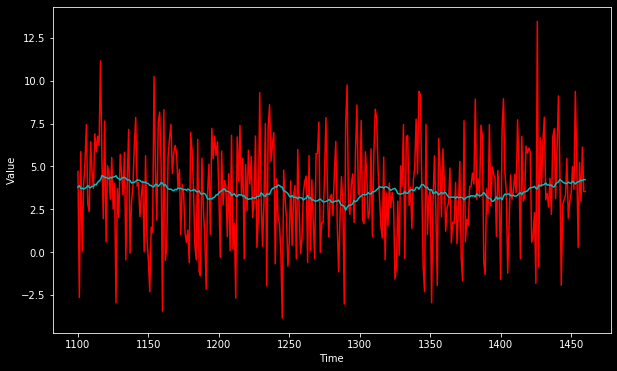

In [61]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split_time-365:], 'r-')
plot_series(time_valid, diff_moving_avg, 'c-')
plt.show()

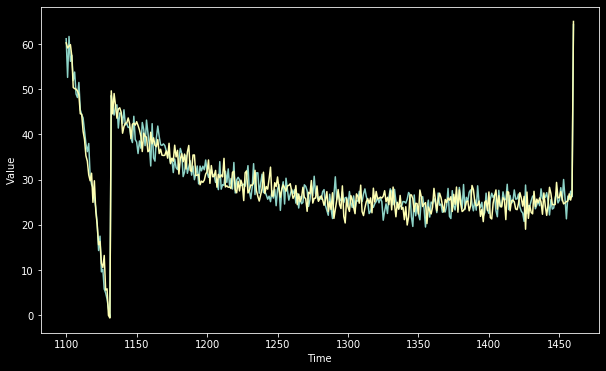

In [62]:
diff_moving_avg_plus_past = series[split_time - 365 : -365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

In [63]:
print('MSE', keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print('MAE', keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

MSE 8.498155
MAE 2.3271794


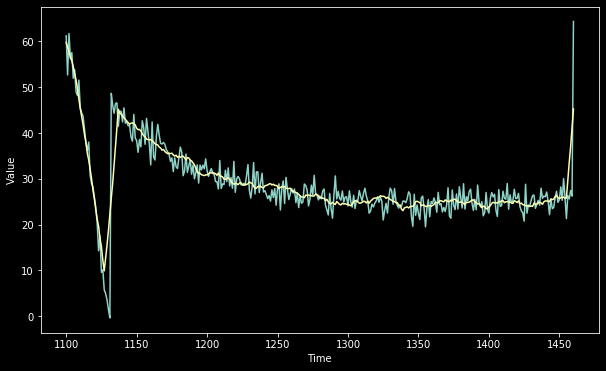

In [64]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time-370 : -360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
            
# EXPECTED OUTPUT:
# Similar chart to above, but the overlaid projections are much smoother

In [65]:
print('MSE:', keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print('MAE:', keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

MSE: 12.527959
MAE: 2.2034433
